##  Clustering-Based Customer Segmentation from Online Retail Data

In [5]:
import numpy as np
import pandas as pd


In [6]:
dataset = pd.read_csv('Online Retail.csv', encoding='latin1')
print(dataset.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  01/12/2010 08:26       2.55     17850.0  United Kingdom  
1  01/12/2010 08:26       3.39     17850.0  United Kingdom  
2  01/12/2010 08:26       2.75     17850.0  United Kingdom  
3  01/12/2010 08:26       3.39     17850.0  United Kingdom  
4  01/12/2010 08:26       3.39     17850.0  United Kingdom  


In [7]:
dataset.shape

(541909, 8)

In [4]:
dataset.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [10]:
dataset.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
dataset.drop_duplicates()
print(dataset.shape)

(541909, 8)


### Cleaning the data

In [9]:
dataset.dropna(subset=['CustomerID'])
print(dataset.shape)

(541909, 8)


In [10]:
dataset = dataset[dataset['Country'] == 'United Kingdom']
print(dataset.shape)

(495478, 8)


In [11]:
dataset = dataset[~dataset['InvoiceNo'].str.startswith('C')]
print(dataset.shape)

(487622, 8)


### Feature Engineering

In [12]:
dataset["InvoiceDate"] = pd.to_datetime(dataset["InvoiceDate"], format='mixed', dayfirst=True)
max_date = dataset["InvoiceDate"].max()
print(max_date)

2011-12-09 12:49:00


In [13]:
dataset["Recency"] = (max_date - dataset["InvoiceDate"]).dt.days
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 487622 entries, 0 to 541893
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    487622 non-null  object        
 1   StockCode    487622 non-null  object        
 2   Description  486168 non-null  object        
 3   Quantity     487622 non-null  int64         
 4   InvoiceDate  487622 non-null  datetime64[ns]
 5   UnitPrice    487622 non-null  float64       
 6   CustomerID   354345 non-null  float64       
 7   Country      487622 non-null  object        
 8   Recency      487622 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 37.2+ MB


In [14]:
frequency_df = dataset.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency_df.rename(columns={'InvoiceNo': 'Frequency'}, inplace=True)

In [15]:
dataset['TotalPrice'] = dataset['Quantity'] * dataset['UnitPrice']
monetary_df = dataset.groupby('CustomerID')['TotalPrice'].sum().reset_index()
monetary_df.rename(columns={'TotalPrice': 'Monetary'}, inplace=True)

In [16]:
rfm_df = frequency_df.merge(monetary_df, on='CustomerID').merge(dataset.groupby('CustomerID')['Recency'].min().reset_index(), on='CustomerID')

In [17]:
print(rfm_df.head())

   CustomerID  Frequency  Monetary  Recency
0     12346.0          1  77183.60      325
1     12747.0         11   4196.01        1
2     12748.0        210  33719.73        0
3     12749.0          5   4090.88        3
4     12820.0          4    942.34        2


In [18]:
rfm_df.shape

(3921, 4)

### Standadization

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Frequency', 'Monetary', 'Recency']])
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Frequency', 'Monetary', 'Recency'])
print(rfm_scaled_df.head())

   Frequency   Monetary   Recency
0  -0.450546  10.068174  2.349480
1   0.937411   0.311738 -0.906268
2  28.557767   4.258248 -0.916317
3   0.104637   0.297685 -0.886171
4  -0.034159  -0.123189 -0.896220


### Visualization of RFM distribution

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

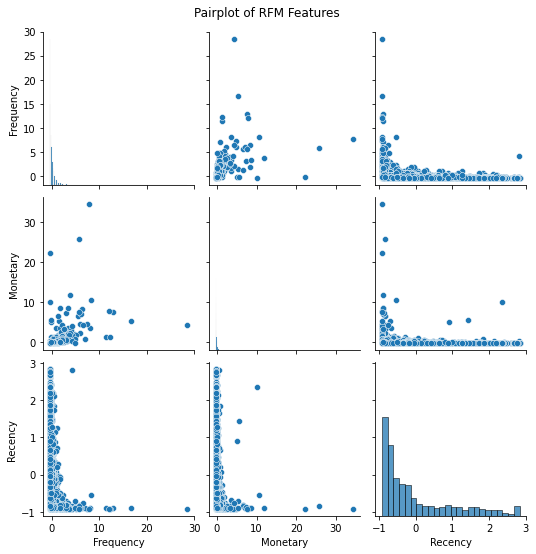

In [21]:
sns.pairplot(rfm_scaled_df[['Frequency', 'Monetary', 'Recency']])
plt.suptitle('Pairplot of RFM Features', y=1.02)
plt.show()

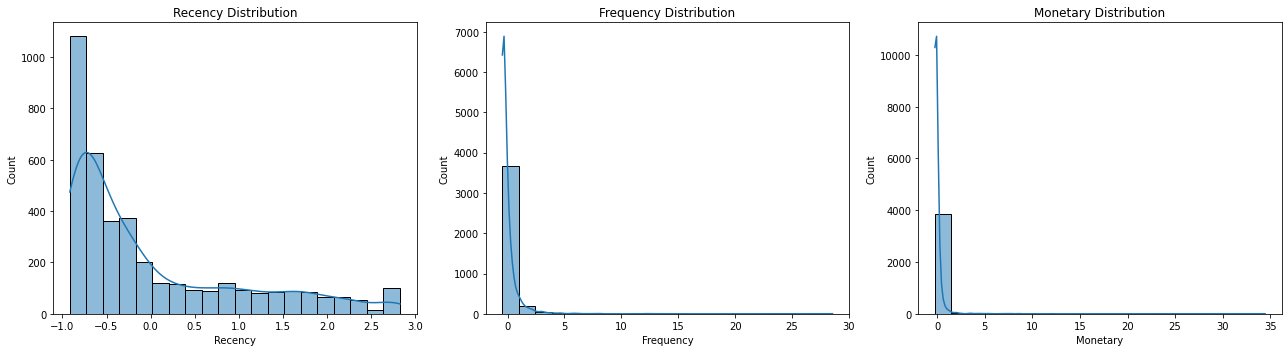

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

sns.histplot(rfm_scaled_df['Recency'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Recency Distribution')

sns.histplot(rfm_scaled_df['Frequency'], bins=20, kde=True, ax=axes[1])
axes[1].set_title('Frequency Distribution')

sns.histplot(rfm_scaled_df['Monetary'], bins=20, kde=True, ax=axes[2])
axes[2].set_title('Monetary Distribution')

plt.tight_layout()
plt.show()

### Applying and Analyzing Clustering Methods 

#### K-Means Clustering 

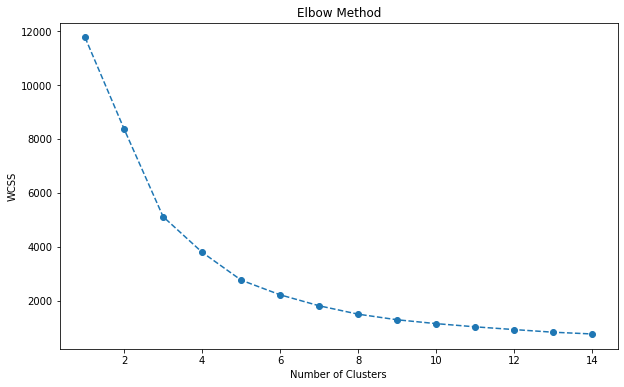

In [22]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(rfm_scaled_df)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 15), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

##### Optimal Number of Clusters = 3

In [37]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=10)
kmeans.fit(rfm_scaled_df)

# Adding the cluster labels to the unscaled RFM DataFrame
rfm_df['KMeans_Cluster'] = kmeans.labels_

# Reporting the cluster centroids
cluster_centroids_scaled = kmeans.cluster_centers_
cluster_centroids_unscaled = scaler.inverse_transform(cluster_centroids_scaled)
centroids_df = pd.DataFrame(cluster_centroids_unscaled, columns=['Frequency', 'Monetary', 'Recency'])

print("K-Means Cluster Centroids:")
print(centroids_df)

K-Means Cluster Centroids:
   Frequency      Monetary     Recency
0   4.715713   1784.416042   39.738456
1   1.591365    487.595081  242.777108
2  59.956522  71494.413043   18.391304


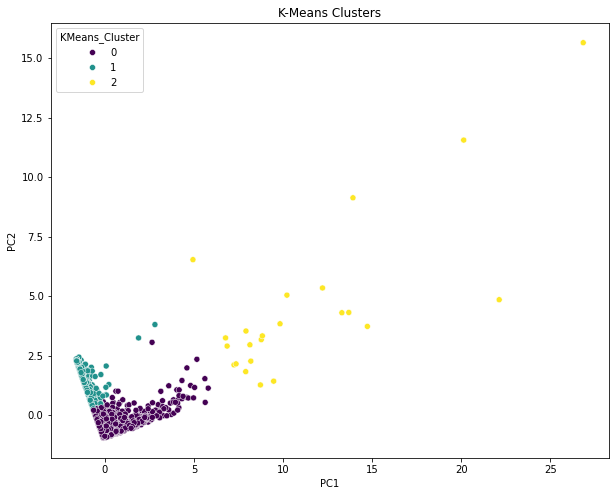

In [93]:
from sklearn.decomposition import PCA

# Perform PCA to reduce data to 2 dimensions
pca = PCA(n_components=2)
principal_components = pca.fit_transform(rfm_scaled_df)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Add the K-Means cluster labels to the PCA DataFrame
pca_df['KMeans_Cluster'] = rfm_df['KMeans_Cluster']

# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='KMeans_Cluster', data=pca_df, palette='viridis', legend='full')
plt.title('K-Means Clusters')
plt.show()

##### Evaluation of K-means Clustering

In [39]:
from sklearn.metrics import silhouette_score

kmeans_labels = rfm_df['KMeans_Cluster']
silhouette_avg = silhouette_score(rfm_scaled_df, kmeans_labels)

print(f"The average Silhouette Score for K-Means is: {silhouette_avg}")

The average Silhouette Score for K-Means is: 0.5807441822366912


In [40]:
intra_cluster_distance = kmeans.inertia_
print(f"K-Means Intra-cluster Distance (WCSS): {intra_cluster_distance:.2f}")

K-Means Intra-cluster Distance (WCSS): 5114.68


In [41]:
from sklearn.metrics.pairwise import euclidean_distances

centroid_distances = euclidean_distances(kmeans.cluster_centers_)
# Get the unique distances 
unique_distances = centroid_distances[np.triu_indices(len(centroid_distances), k=1)]
inter_cluster_distance = np.mean(unique_distances)
print(f"K-Means Average Inter-cluster Distance: {inter_cluster_distance:.2f}")

K-Means Average Inter-cluster Distance: 8.95


##### Customer Segments 

Cluster 0: This segment is characterized by a moderate average frequency and monetary value, with a relatively low average recency. These customers are considered to be active, consistent buyers who have recently made purchases and contribute a solid amount to revenue.

Cluster 1: This cluster is defined by its low average frequency and monetary value, and a very high average recency. This group is identified as being inactive, with purchases having been made a long time ago and at low transactional volumes.

Cluster 2: This segment is distinguished by a very high average frequency and exceptionally high average monetary value, combined with a very low recency. This group is interpreted as the most valuable and highly engaged customers, who are responsible for a significant portion of the company's revenue.

#### Hierarchical Clustering (AGNES) 

In [42]:
from scipy.cluster.hierarchy import dendrogram, linkage

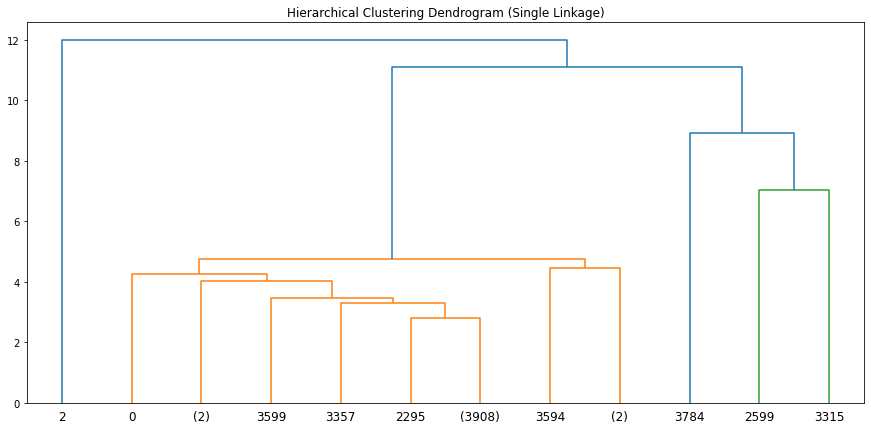

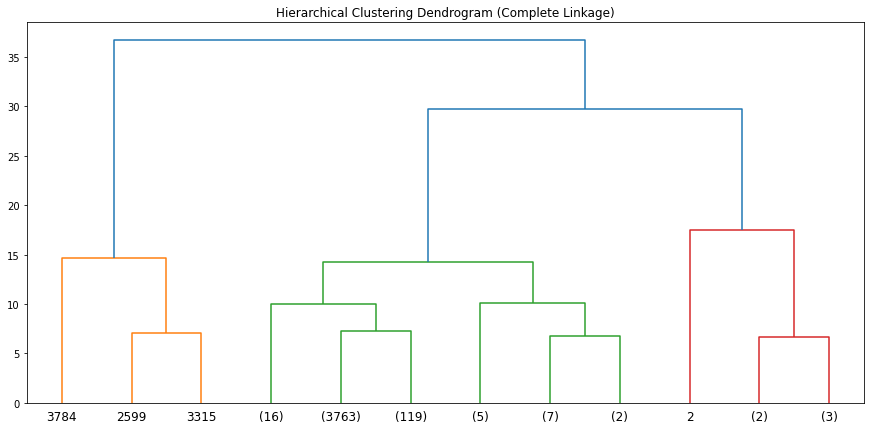

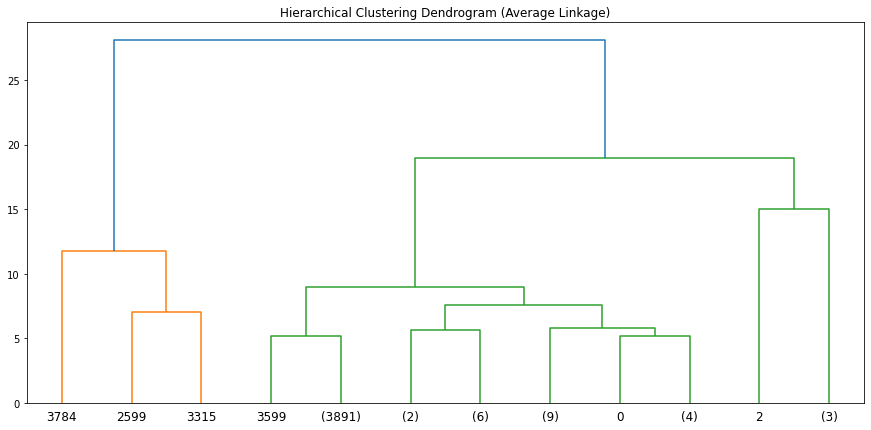

In [43]:

# Single Linkage
plt.figure(figsize=(15, 7))
plt.title('Hierarchical Clustering Dendrogram (Single Linkage)')
single_linkage = linkage(rfm_scaled_df, method='single')
dendrogram(single_linkage, truncate_mode='lastp', p=12)
plt.show()

# Complete Linkage
plt.figure(figsize=(15, 7))
plt.title('Hierarchical Clustering Dendrogram (Complete Linkage)')
complete_linkage = linkage(rfm_scaled_df, method='complete')
dendrogram(complete_linkage, truncate_mode='lastp', p=12)
plt.show()

# Average Linkage
plt.figure(figsize=(15, 7))
plt.title('Hierarchical Clustering Dendrogram (Average Linkage)')
average_linkage = linkage(rfm_scaled_df, method='average')
dendrogram(average_linkage, truncate_mode='lastp', p=12)
plt.show()

#### Deciding the number of clusters

To decide the optimal number of clusters by observing the dendrograms, the longest vertical lines that are not attached to other vertical lines have to be identified.They represent the largest distances at which clusters are merged.
Then a specific point on the y-axis has to be found where a significant vertical distance exists between two merges. This indicates that the clusters being joined are quite dissimilar.
After it can be imagined that drawing a horizontal line across the dendrogram at that height.
Then the number of vertical lines that the imagined horizontal line intersects represents the number of clusters. The longer the vertical line, the more distinct the clusters are from each other.

###### Number of identified clusters for single linkage = 5
###### Number of identified clusters for complete linkage = 4
###### Number of identified clusters for average linkage = 4

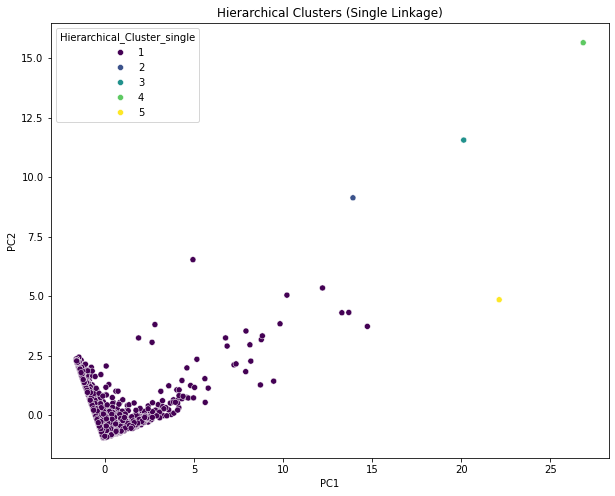

In [47]:
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import fcluster

n_clusters = 5
hc_labels = fcluster(single_linkage, n_clusters, criterion='maxclust')
rfm_df['Hierarchical_Cluster_single'] = hc_labels

# Perform PCA on the full scaled dataset
pca = PCA(n_components=2)
principal_components = pca.fit_transform(rfm_scaled_df)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Hierarchical_Cluster_single'] = rfm_df['Hierarchical_Cluster_single']

# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Hierarchical_Cluster_single', data=pca_df, palette='viridis', legend='full')
plt.title('Hierarchical Clusters (Single Linkage)')
plt.show()

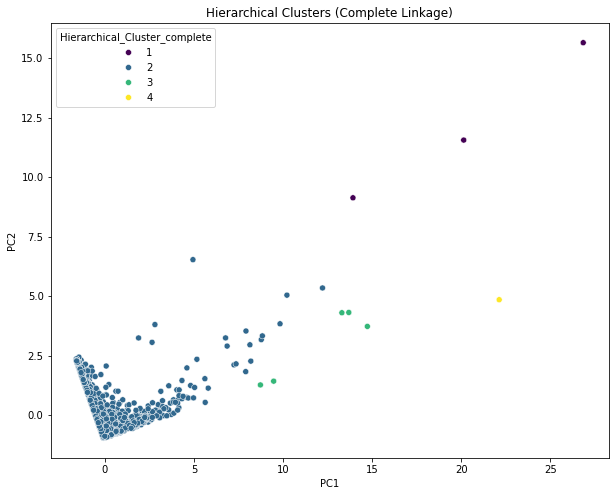

In [48]:
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import fcluster

n_clusters = 4
hc_labels = fcluster(complete_linkage, n_clusters, criterion='maxclust')
rfm_df['Hierarchical_Cluster_complete'] = hc_labels

# Perform PCA on the full scaled dataset
pca = PCA(n_components=2)
principal_components = pca.fit_transform(rfm_scaled_df)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Hierarchical_Cluster_complete'] = rfm_df['Hierarchical_Cluster_complete']

# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Hierarchical_Cluster_complete', data=pca_df, palette='viridis', legend='full')
plt.title('Hierarchical Clusters (Complete Linkage)')
plt.show()

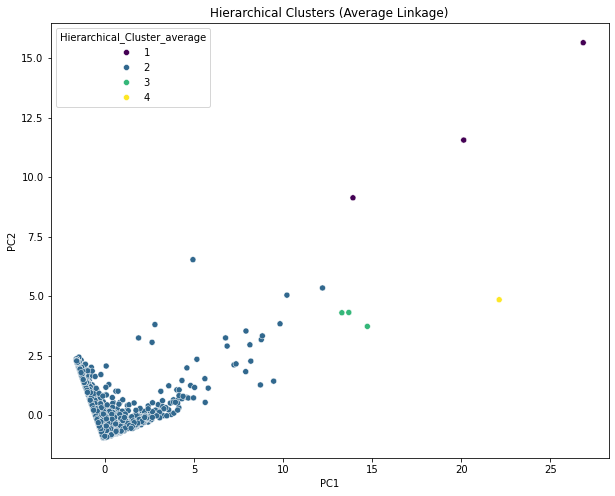

In [49]:
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import fcluster

n_clusters = 4
hc_labels = fcluster(average_linkage, n_clusters, criterion='maxclust')
rfm_df['Hierarchical_Cluster_average'] = hc_labels

# Perform PCA on the full scaled dataset
pca = PCA(n_components=2)
principal_components = pca.fit_transform(rfm_scaled_df)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Hierarchical_Cluster_average'] = rfm_df['Hierarchical_Cluster_average']

# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Hierarchical_Cluster_average', data=pca_df, palette='viridis', legend='full')
plt.title('Hierarchical Clusters (Average Linkage)')
plt.show()

#### Evaluation of Heirarchial Clustering

In [51]:
from sklearn.metrics import silhouette_score

In [52]:
silhouette_avg = silhouette_score(rfm_scaled_df, rfm_df['Hierarchical_Cluster_single'])
print(f"The average Silhouette Score for Hierarchical Clustering (Single Linkage) is: {silhouette_avg}")

silhouette_avg = silhouette_score(rfm_scaled_df, rfm_df['Hierarchical_Cluster_complete'])
print(f"The average Silhouette Score for Hierarchical Clustering (Complete Linkage) is: {silhouette_avg}")

silhouette_avg = silhouette_score(rfm_scaled_df, rfm_df['Hierarchical_Cluster_average'])
print(f"The average Silhouette Score for Hierarchical Clustering (Average Linkage) is: {silhouette_avg}")   

The average Silhouette Score for Hierarchical Clustering (Single Linkage) is: 0.9307561211743716
The average Silhouette Score for Hierarchical Clustering (Complete Linkage) is: 0.8931872741159214
The average Silhouette Score for Hierarchical Clustering (Average Linkage) is: 0.9020722798073418


In [54]:
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np

# Calculate Intra-cluster Distance (Average pairwise distance within each cluster)
intra_distances = []
for label in np.unique(rfm_df['Hierarchical_Cluster_single']):
    cluster_points = rfm_scaled_df[rfm_df['Hierarchical_Cluster_single'] == label]
    if len(cluster_points) > 1:
        intra_distances.append(np.mean(pairwise_distances(cluster_points)))

print(f"Hierarchical Average Intra-cluster Distance (Single Linkage): {np.mean(intra_distances):.2f}")

# Calculate Inter-cluster Distance (Average pairwise distance between all pairs of clusters)
inter_distances = []
unique_labels = np.unique(rfm_df['Hierarchical_Cluster_single'])
for i in range(len(unique_labels)):
    for j in range(i + 1, len(unique_labels)):
        cluster_i_points = rfm_scaled_df[rfm_df['Hierarchical_Cluster_single'] == unique_labels[i]]
        cluster_j_points = rfm_scaled_df[rfm_df['Hierarchical_Cluster_single'] == unique_labels[j]]
        inter_distances.append(np.mean(pairwise_distances(cluster_i_points, cluster_j_points)))

print(f"Hierarchical Average Inter-cluster Distance (Single Linkage): {np.mean(inter_distances):.2f}")

Hierarchical Average Intra-cluster Distance (Single Linkage): 1.50
Hierarchical Average Inter-cluster Distance (Single Linkage): 24.57


In [55]:
# Calculate Intra-cluster Distance (Average pairwise distance within each cluster)
intra_distances = []
for label in np.unique(rfm_df['Hierarchical_Cluster_complete']):
    cluster_points = rfm_scaled_df[rfm_df['Hierarchical_Cluster_complete'] == label]
    if len(cluster_points) > 1:
        intra_distances.append(np.mean(pairwise_distances(cluster_points)))

print(f"Hierarchical Average Intra-cluster Distance (Complete Linkage): {np.mean(intra_distances):.2f}")

# Calculate Inter-cluster Distance (Average pairwise distance between all pairs of clusters)
inter_distances = []
unique_labels = np.unique(rfm_df['Hierarchical_Cluster_complete'])
for i in range(len(unique_labels)):
    for j in range(i + 1, len(unique_labels)):
        cluster_i_points = rfm_scaled_df[rfm_df['Hierarchical_Cluster_complete'] == unique_labels[i]]
        cluster_j_points = rfm_scaled_df[rfm_df['Hierarchical_Cluster_complete'] == unique_labels[j]]
        inter_distances.append(np.mean(pairwise_distances(cluster_i_points, cluster_j_points)))

print(f"Hierarchical Average Inter-cluster Distance (Complete Linkage): {np.mean(inter_distances):.2f}")

Hierarchical Average Intra-cluster Distance (Complete Linkage): 4.08
Hierarchical Average Inter-cluster Distance (Complete Linkage): 24.33


In [56]:
# Calculate Intra-cluster Distance (Average pairwise distance within each cluster)
intra_distances = []
for label in np.unique(rfm_df['Hierarchical_Cluster_average']):
    cluster_points = rfm_scaled_df[rfm_df['Hierarchical_Cluster_average'] == label]
    if len(cluster_points) > 1:
        intra_distances.append(np.mean(pairwise_distances(cluster_points)))

print(f"Hierarchical Average Intra-cluster Distance (Average Linkage): {np.mean(intra_distances):.2f}")

# Calculate Inter-cluster Distance (Average pairwise distance between all pairs of clusters)
inter_distances = []
unique_labels = np.unique(rfm_df['Hierarchical_Cluster_average'])
for i in range(len(unique_labels)):
    for j in range(i + 1, len(unique_labels)):
        cluster_i_points = rfm_scaled_df[rfm_df['Hierarchical_Cluster_average'] == unique_labels[i]]
        cluster_j_points = rfm_scaled_df[rfm_df['Hierarchical_Cluster_average'] == unique_labels[j]]
        inter_distances.append(np.mean(pairwise_distances(cluster_i_points, cluster_j_points)))

print(f"Hierarchical Average Inter-cluster Distance (Average Linkage): {np.mean(inter_distances):.2f}")

Hierarchical Average Intra-cluster Distance (Average Linkage): 3.54
Hierarchical Average Inter-cluster Distance (Average Linkage): 24.15


In [62]:
cluster_summary = rfm_df.groupby('Hierarchical_Cluster_single').agg(
    Recency=('Recency', 'mean'),
    Frequency=('Frequency', 'mean'),
    Monetary=('Monetary', 'mean'),
    Count=('CustomerID', 'count')
).reset_index()

print("Hierarchical Cluster Centroids (Single Linkage):")
print(cluster_summary)

Hierarchical Cluster Centroids (Single Linkage):
   Hierarchical_Cluster_single    Recency   Frequency      Monetary  Count
0                            1  91.279806    4.169262    1698.23621   3917
1                            2   0.000000    2.000000  168472.50000      1
2                            3   7.000000   46.000000  194550.79000      1
3                            4   0.000000   60.000000  259657.30000      1
4                            5   0.000000  210.000000   33719.73000      1


Cluster 1: This is the largest segment by a significant margin. It is defined by a high average recency and low average frequency and monetary values. This indicates that the majority of customers in this cluster are considered to be at-risk or inactive, as a considerable amount of time has passed since their last low-value transaction.

Cluster 2: This segment consists of a single customer with an exceptionally high monetary value and a low frequency. Purchases by this customer were made very recently, positioning them as a high-value, new customer.

Cluster 3: This small cluster is identified by its high frequency and very high monetary value. With a low recency, this group is considered to contain highly engaged and profitable customers.

Cluster 4: This segment is represented by a single customer with a very low recency, high frequency, and extremely high monetary value. This customer is considered a top-tier contributor due to recent, frequent, and high-value transactions.

Cluster 5: This cluster is also a single-customer segment with very low recency and extremely high frequency. The monetary value is moderate in comparison, suggesting this customer is a very frequent but mid-range spender.

In [63]:
cluster_summary = rfm_df.groupby('Hierarchical_Cluster_complete').agg(
    Recency=('Recency', 'mean'),
    Frequency=('Frequency', 'mean'),
    Monetary=('Monetary', 'mean'),
    Count=('CustomerID', 'count')
).reset_index()

print("Hierarchical Cluster Centroids (Complete Linkage):")
print(cluster_summary)

Hierarchical Cluster Centroids (Complete Linkage):
   Hierarchical_Cluster_complete    Recency  Frequency       Monetary  Count
0                              1   2.333333   36.00000  207560.196667      3
1                              2  91.394939    4.04908    1653.389411   3912
2                              3   1.200000   98.20000   36786.372000      5
3                              4   0.000000  210.00000   33719.730000      1


Cluster 1: This is a small group of three customers with extremely high average monetary value and a moderate frequency. Their very low recency indicates that they are high-spending, recently active customers.

Cluster 2: This is the largest cluster, with a very high average recency and low frequency and monetary values. This group is interpreted as at-risk or churned customers, as they have not made a purchase in a long time and were low-value contributors.

Cluster 3: This small segment of five customers is characterized by very high frequency and monetary values, coupled with a very low recency. These customers are considered to be highly frequent and valuable buyers.

Cluster 4: This segment is a single, top-tier customer with an extremely high frequency and significant monetary value, and a recency of zero. This individual is a very frequent and top-spending customer who has recently made a purchase.

In [64]:
cluster_summary = rfm_df.groupby('Hierarchical_Cluster_average').agg(
    Recency=('Recency', 'mean'),
    Frequency=('Frequency', 'mean'),
    Monetary=('Monetary', 'mean'),
    Count=('CustomerID', 'count')
).reset_index()

print("Hierarchical Cluster Centroids (Average Linkage):")
print(cluster_summary)

Hierarchical Cluster Centroids (Average Linkage):
   Hierarchical_Cluster_average    Recency   Frequency       Monetary  Count
0                             1   2.333333   36.000000  207560.196667      3
1                             2  91.349004    4.092744    1658.509436   3914
2                             3   1.000000  104.000000   53528.433333      3
3                             4   0.000000  210.000000   33719.730000      1


Cluster 1: This is a small group of three customers. It is characterized by an extremely high average monetary value and a moderate frequency. Their very low recency indicates that they are high-spending, recently active customers.

Cluster 2: This is the largest cluster by a significant margin. It is identified by a very high average recency and low average frequency and monetary values. This group is interpreted as at-risk or churned customers, as a significant amount of time has passed since their last low-value transaction.

Cluster 3: This small segment of three customers is characterized by a very low average recency, extremely high frequency, and high monetary value. These customers are considered to be highly frequent and valuable buyers.

Cluster 4: This segment is a single, top-tier customer. It is defined by an extremely high frequency, significant monetary value, and a recency of zero, indicating a purchase was made on the most recent date. This individual is a very frequent and top-spending customer.

#### DBSCAN

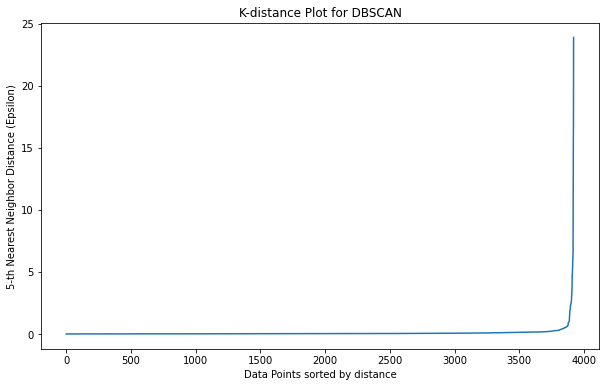

In [82]:
from sklearn.neighbors import NearestNeighbors

# min_samples ≥ Number of Dimensions + 1
min_samples = 5

# Use NearestNeighbors to find the optimal eps
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(rfm_scaled_df)
distances, indices = neighbors_fit.kneighbors(rfm_scaled_df)
distances = np.sort(distances[:, min_samples - 1], axis=0)

# Plot the K-distance plot
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-distance Plot for DBSCAN')
plt.xlabel('Data Points sorted by distance')
plt.ylabel(f'{min_samples}-th Nearest Neighbor Distance (Epsilon)')
plt.show()


In [75]:
print(distances[-100:])

[ 0.36957199  0.37032272  0.3745307   0.37947788  0.38154548  0.38977214
  0.39349114  0.4013978   0.40871171  0.41065405  0.41334722  0.4168847
  0.4168847   0.41778056  0.4207753   0.42963706  0.43172586  0.43423416
  0.43490847  0.44340519  0.44435492  0.45498635  0.46170823  0.46218621
  0.46547051  0.47088054  0.4716054   0.4742699   0.47606624  0.49245587
  0.49828716  0.51180269  0.51280684  0.52022909  0.52128034  0.52889652
  0.5312922   0.5410078   0.54839769  0.55053255  0.55836109  0.55858092
  0.56047339  0.56710201  0.56729     0.56729     0.56911614  0.6052213
  0.61048643  0.61422985  0.61813158  0.63672701  0.65193202  0.6575331
  0.6575331   0.70638563  0.72172382  0.73172426  0.91204797  0.92148984
  0.92756157  0.94633449  0.96531214  0.97204133  1.01297658  1.02533006
  1.03999896  1.25900998  1.54430428  1.6644894   1.84006069  1.91862937
  1.96938481  1.98936721  2.05211762  2.33051211  2.36602141  2.40126544
  2.40552777  2.44029194  2.59867784  2.62906835  2.63

In [83]:
from kneed import KneeLocator
kneedle = KneeLocator(range(len(distances)), distances, S=1.0, curve="convex", direction="increasing")
best_eps = distances[kneedle.knee]
print("Best eps:", best_eps)

Best eps: 0.6575330988456021


Optimal value for eps = 0.6575

In [94]:
from sklearn.cluster import DBSCAN

eps = 0.6575
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(rfm_scaled_df)
rfm_df['DBSCAN_Cluster'] = dbscan_labels
print("DBSCAN Cluster Labels:", np.unique(dbscan_labels))

DBSCAN Cluster Labels: [-1  0]


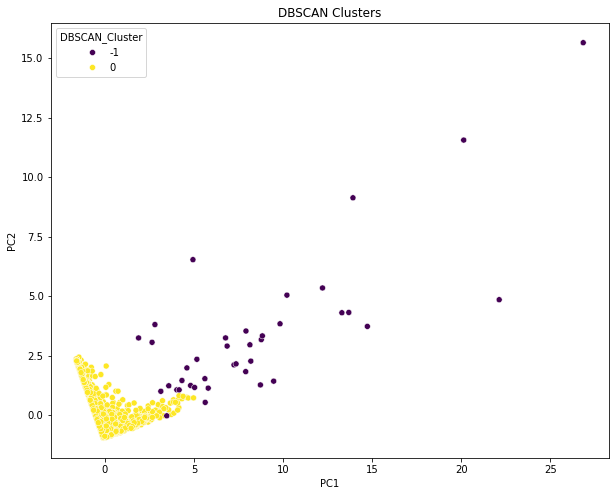

In [95]:
from sklearn.decomposition import PCA

# Perform PCA to reduce data to 2 dimensions
pca = PCA(n_components=2)
principal_components = pca.fit_transform(rfm_scaled_df)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Add the DBSCAN cluster labels to the PCA DataFrame
pca_df['DBSCAN_Cluster'] = rfm_df['DBSCAN_Cluster']

# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='DBSCAN_Cluster', data=pca_df, palette='viridis', legend='full')
plt.title('DBSCAN Clusters')
plt.show()

#### DBSCAN cluster evaluation

In [87]:
from sklearn.metrics import silhouette_score

# Filter out the noise points (-1) for Silhouette Score calculation
filtered_labels = rfm_df['DBSCAN_Cluster'][rfm_df['DBSCAN_Cluster'] != -1]
filtered_data = rfm_scaled_df[rfm_df['DBSCAN_Cluster'] != -1]

# Only calculate the score if more than one cluster was formed
if len(np.unique(filtered_labels)) > 1:
    silhouette_avg = silhouette_score(filtered_data, filtered_labels)
    print(f"The average Silhouette Score for DBSCAN is: {silhouette_avg:.2f}")
else:
    print("Cannot calculate Silhouette Score: DBSCAN did not form more than one cluster.")

Cannot calculate Silhouette Score: DBSCAN did not form more than one cluster.


In [89]:
from sklearn.metrics.pairwise import pairwise_distances

# Filter out noise points
filtered_labels = rfm_df['DBSCAN_Cluster'][rfm_df['DBSCAN_Cluster'] != -1]
filtered_data = rfm_scaled_df[rfm_df['DBSCAN_Cluster'] != -1]
unique_labels = np.unique(filtered_labels)

# Calculate Intra-cluster Distance
intra_distances = []
for label in unique_labels:
    cluster_points = filtered_data[filtered_labels == label]
    if len(cluster_points) > 1:
        intra_distances.append(np.mean(pairwise_distances(cluster_points)))

print(f"DBSCAN Average Intra-cluster Distance: {np.mean(intra_distances):.2f}")

# Calculate Inter-cluster Distance
inter_distances = []
for i in range(len(unique_labels)):
    for j in range(i + 1, len(unique_labels)):
        cluster_i_points = filtered_data[filtered_labels == unique_labels[i]]
        cluster_j_points = filtered_data[filtered_labels == unique_labels[j]]
        inter_distances.append(np.mean(pairwise_distances(cluster_i_points, cluster_j_points)))

print(f"DBSCAN Average Inter-cluster Distance: {np.mean(inter_distances):.2f}")

DBSCAN Average Intra-cluster Distance: 1.37
DBSCAN Average Inter-cluster Distance: nan


c:\Users\Shani\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Shani\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [91]:
rfm_df_filtered = rfm_df[rfm_df['DBSCAN_Cluster'] != -1]

cluster_summary = rfm_df_filtered.groupby('DBSCAN_Cluster').agg(
    Recency=('Recency', 'mean'),
    Frequency=('Frequency', 'mean'),
    Monetary=('Monetary', 'mean'),
    Count=('CustomerID', 'count')
).reset_index()

print("DBSCAN Cluster Centroids:")
print(cluster_summary)

DBSCAN Cluster Centroids:
   DBSCAN_Cluster    Recency  Frequency     Monetary  Count
0               0  91.763266   3.831788  1344.919342   3882
